In [38]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import os

## **IMAGE LOADING**

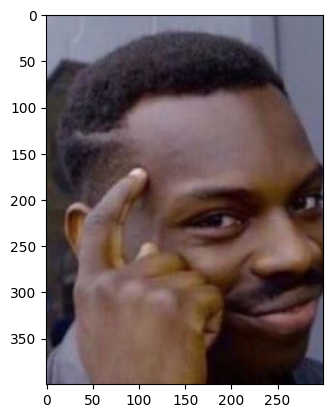

In [39]:
img = torchvision.io.read_image("task4.jpg")
img = img.permute(1,2,0).float() / 255.0
img = img[0:400, 100:400]
H,W,C = img.shape
plt.imshow(img)

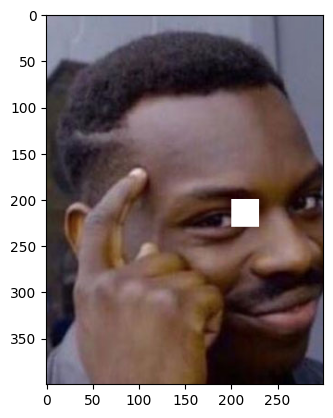

In [73]:
mask1 = torch.ones((H, W),dtype=torch.bool)
mask1[200:230, 200:230] = 0

masked_img1 = img.clone()
masked_img1[~mask1] = 1
plt.imshow(masked_img1)

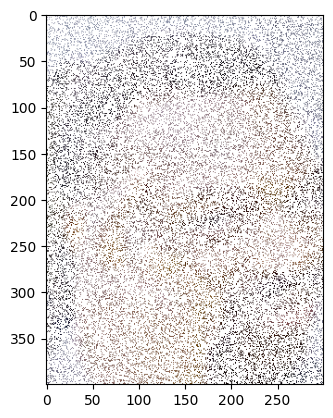

In [88]:
num_pixels = int(0.8 * H * W)
total_pixels = H * W
idx = torch.randperm(total_pixels)[:num_pixels]

mask2 = torch.ones((H, W),dtype=torch.bool)
mask2.view(-1)[idx] = False

masked_img2 = img.clone()
masked_img2[~mask2] = 1
plt.imshow(masked_img2)

## **Gradient Descent**

In [42]:
def lowRankDescent(img, mask, rank=30, lr=0.01, epochs=5000):
    H, W, C = img.shape
    img_t = img.clone()
    mask_t = mask.clone()

    U = torch.rand(H, rank, C, requires_grad=True)
    V = torch.rand(W, rank, C, requires_grad=True)

    optimizer = torch.optim.Adam([U, V],lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()

        recon = torch.ones((H,W,C))
        for c in range(C):
            recon[:,:,c] = U[:,:,c] @ V[:,:,c].T

        loss = torch.mean(((recon - img_t)[mask_t]) ** 2)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.6f}")
    
    return recon.detach()

In [43]:
def compute_metrics_torch(gt, pred):
    mse = torch.mean((gt - pred) ** 2)
    rmse = torch.sqrt(mse)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return rmse.item(), psnr.item()

Epoch 0, Loss = 52.897465
Epoch 500, Loss = 0.050492
Epoch 1000, Loss = 0.018279
Epoch 1500, Loss = 0.006866


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.047351692..0.94509804].


RMSE: 0.0607, PSNR: 24.33 dB


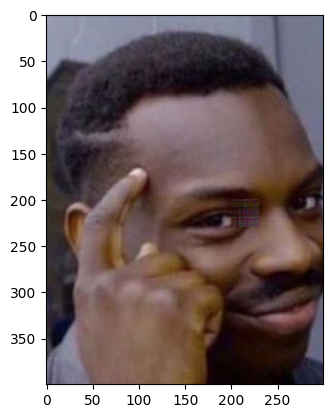

In [44]:
recon = lowRankDescent(img, mask1, rank=30, lr=1e-2, epochs=2000)

# Visualization (replace missing pixels with reconstruction)
final_img1 = img.clone()
final_img1[~mask1] = recon[~mask1]
plt.imshow(final_img1)

rmse, psnr = compute_metrics_torch(img, recon)
print(f"RMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")

Epoch 0, Loss = 51.518288
Epoch 500, Loss = 0.046770
Epoch 1000, Loss = 0.017444
Epoch 1500, Loss = 0.007185


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23963799..0.94509804].


RMSE: 0.0735, PSNR: 22.68 dB


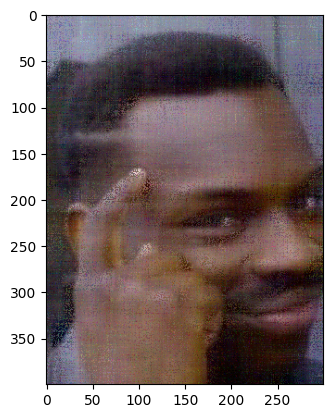

In [83]:
recon = lowRankDescent(img, mask2, rank=30, lr=1e-2, epochs=2000)

# Visualization (replace missing pixels with reconstruction)
final_img2 = img.clone()
final_img2[~mask2] = recon[~mask2]
plt.imshow(final_img2)

rmse, psnr = compute_metrics_torch(img, recon)
print(f"RMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")

##### The reconstruction in is much better in the latter case as the missing pixel values have their vicinty pixels to rely on, but in case of the entire blocks being gone the model doesn't know what object is there in the square thus it fails

## **ALS**

In [ ]:
def ALS(img, mask, rank=30, epochs=10):
    H, W, C = img.shape
    U = torch.rand(H, rank, C)
    V = torch.rand(W, rank, C)

    for epoch in range(epochs):
        for c in range(C):
            # Update U row by row
            for i in range(H):
                known_idx = mask[i, :]  # only columns that are known
                if known_idx.sum() == 0:
                    continue
                V_known = V[known_idx, :, c]       # shape (num_known, rank)
                img_known = img[i, known_idx, c]  # shape (num_known,)
                U[i, :, c] = torch.linalg.lstsq(V_known, img_known).solution

            # Update V column by column
            for j in range(W):
                known_idx = mask[:, j]  # only rows that are known
                if known_idx.sum() == 0:
                    continue
                U_known = U[known_idx, :, c]
                img_known = img[known_idx, j, c]
                V[j, :, c] = torch.linalg.lstsq(U_known, img_known).solution

        # Reconstruct
        recon = torch.einsum('hrc,wrc->hwc', U, V)
        loss = torch.mean(((recon - img) * mask.unsqueeze(-1))**2)
        if epoch % 2 == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.6f}")

    return recon


Epoch 0, Loss = 0.000488
Epoch 2, Loss = 0.000138
Epoch 4, Loss = 0.000131
Epoch 6, Loss = 0.000129
Epoch 8, Loss = 0.000128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19830526..1.0877701].


RMSE: 0.0267, PSNR: 31.46 dB


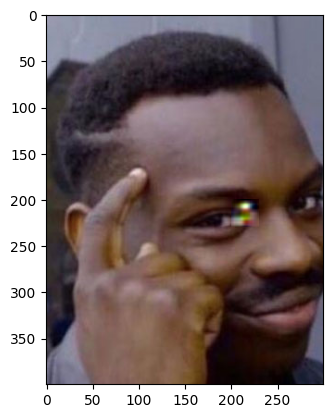

In [ ]:
recon = ALS(img, mask1, rank=30,epochs=4)

# Visualization (replace missing pixels with reconstruction)
final_img1 = img.clone()
final_img1[~mask1] = recon[~mask1]
plt.imshow(final_img1)

rmse, psnr = compute_metrics_torch(img, recon)
print(f"RMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")

Epoch 0, Loss = 0.002382
Epoch 2, Loss = 0.000090


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09711428..0.9883059].


RMSE: 0.0157, PSNR: 36.11 dB


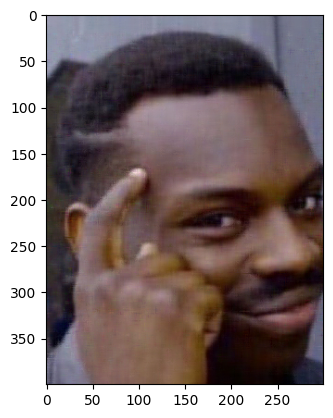

In [84]:
recon = ALS(img, mask2, rank=30, epochs=4)

# Visualization (replace missing pixels with reconstruction)
final_img2 = img.clone()
final_img2[~mask2] = recon[~mask2]
plt.imshow(final_img2)

rmse, psnr = compute_metrics_torch(img, recon)
print(f"RMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")

##### We see ALS works way better for the latter case, but like GD it fails in the block case again